<a href="https://colab.research.google.com/github/anupama020412/noun-verb-ambiguity/blob/master/pos_tagger_using_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install  pyconll
! pip install pydot
! pip install graphiz


!pip install tensorflow==2.2.0



ERROR: Could not find a version that satisfies the requirement graphiz (from versions: none)
ERROR: No matching distribution found for graphiz
     |████████████████████████████████| 516.2MB 22kB/s 
     |████████████████████████████████| 3.0MB 39.5MB/s 
     |████████████████████████████████| 460kB 37.7MB/s 
ERROR: tensorflow-text 1.15.0 has requirement tensorflow<1.16,>=1.15.0, but you'll have tensorflow 2.2.0 which is incompatible.
  Found existing installation: tensorboard 2.0.2
    Uninstalling tensorboard-2.0.2:
      Successfully uninstalled tensorboard-2.0.2
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Found existing installation: tensorflow-estimator 2.0.1
    Uninstalling tensorflow-estimator-2.0.1:
      Successfully uninstalled tensorflow-estimator-2.0.1
  Found existing installation: tensorflow 2.0.0
    Uninstalling tensorflow-2.0.0:
      Successfully uninstalled tensorflow-2.0.0


In [ ]:
#https://github.com/soutsios/pos-tagger-bert/blob/master/pos_tagger_bert.ipynb

In [ ]:
from numpy.random import seed
seed(1)
#from tensorflow import set_random_seed
#set_random_seed(2)
import pyconll, keras, pickle, os, random, nltk, datetime, warnings, gc, urllib.request, zipfile, collections
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.metrics.classification import UndefinedMetricWarning

from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
from keras import backend as K
from keras.models import load_model
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
#import tensorflow_text
import warnings
from tqdm import tqdm_notebook
from IPython.display import Image 
#warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
from bert.tokenization import FullTokenizer




# Load Dataset

In [ ]:
import os 
os.getcwd()
os.listdir()

['.config', 'dev.conll', 'test.conll', 'train.conll', 'sample_data']

In [ ]:

def read_conllu(path):
    data = pyconll.load_from_file(path)
    tagged_sentences=[]
    t=0
    for sentence in data:
        tagged_sentence=[]
        for token in sentence:
            if token.upos and token.form:
                t+=1
                tagged_sentence.append((token.form.lower(), token.upos))
                #print("-------")
                print(tagged_sentence)
        tagged_sentences.append(tagged_sentence)
    return tagged_sentences
dev = read_conllu('dev.conll')


[('cleaning', 'VERB')]
[('weathering', 'VERB')]
[('benefit', 'VERB')]
[('man', 'NON-VERB')]
[('questions', 'VERB')]
[('mark', 'VERB')]
[('come', 'VERB')]
[('twisting', 'VERB')]
[('offering', 'VERB')]
[('buy', 'VERB')]
[('plays', 'VERB')]
[('poses', 'VERB')]
[('mix', 'VERB')]
[('coach', 'VERB')]
[('boarding', 'VERB')]
[('exercise', 'NON-VERB')]
[('smithing', 'NON-VERB')]
[('pose', 'NON-VERB')]
[('hiking', 'VERB')]
[('notes', 'NON-VERB')]
[('repeat', 'VERB')]
[('jumping', 'VERB')]
[('shakes', 'VERB')]
[('respect', 'NON-VERB')]
[('circles', 'VERB')]
[('teaching', 'VERB')]
[('hedge', 'VERB')]
[('place', 'VERB')]
[('works', 'NON-VERB')]
[('tack', 'VERB')]
[('letting', 'VERB')]
[('run', 'VERB')]
[('use', 'VERB')]
[('piping', 'NON-VERB')]
[('dating', 'VERB')]
[('watching', 'VERB')]
[('binds', 'VERB')]
[('set', 'NON-VERB')]
[('working', 'VERB')]
[('working', 'VERB')]
[('taste', 'VERB')]
[('mate', 'VERB')]
[('keep', 'VERB')]
[('repeat', 'VERB')]
[('ordering', 'VERB')]
[('test', 'VERB')]
[('buil

In [ ]:
test = read_conllu('test.conll')


Streaming output truncated to the last 5000 lines.
[('attempts', 'VERB')]
[('show', 'VERB')]
[('blooms', 'VERB')]
[('counting', 'VERB')]
[('icing', 'NON-VERB')]
[('watches', 'VERB')]
[('finishing', 'VERB')]
[('leave', 'NON-VERB')]
[('paint', 'VERB')]
[('angers', 'VERB')]
[('dip', 'VERB')]
[('sit', 'VERB')]
[('falls', 'NON-VERB')]
[('falls', 'NON-VERB')]
[('form', 'VERB')]
[('blanket', 'NON-VERB')]
[('returns', 'VERB')]
[('uses', 'NON-VERB')]
[('coordinates', 'NON-VERB')]
[('meet', 'NON-VERB')]
[('heads', 'NON-VERB')]
[('attempt', 'VERB')]
[('moves', 'NON-VERB')]
[('impacts', 'VERB')]
[('release', 'VERB')]
[('leaves', 'NON-VERB')]
[('checking', 'VERB')]
[('scoops', 'NON-VERB')]
[('sleep', 'VERB')]
[('changes', 'VERB')]
[('taking', 'VERB')]
[('host', 'VERB')]
[('trash', 'VERB')]
[('plateaus', 'NON-VERB')]
[('exhibit', 'VERB')]
[('water', 'NON-VERB')]
[('farming', 'NON-VERB')]
[('support', 'VERB')]
[('stretching', 'VERB')]
[('subsoil', 'NON-VERB')]
[('meet', 'VERB')]
[('scanning', 'VERB')

# Training Data

In [ ]:
 #Different value in xpos column and converting them into corresponding verba dn non-verb type 
 'GW',-NON-VERB
 'JJ',-NON-VERB
 'MD',-VERB
 'NN',NON-VERB
 'NNP',NON-VERB
 'NNPS',NON-VERB
 'NNS',NON-VERB
 'PRP',NON-VERB
 'RB',-VERB
 'RP',NON-VERB
 'VB',-VERB
 'VBD',VERB
 'VBG',VERB
 'VBN',VERB
 'VBP',VERB
 'VBZ'VERB





SyntaxError: ignored

 Different values in xpos array of training data and converting them into VERB or NON-VERB type 
 
 'GW',-NON-VERB
 'JJ',-NON-VERB
 'MD',-VERB
 'NN',NON-VERB
 'NNP',NON-VERB
 'NNPS',NON-VERB
 'NNS',NON-VERB
 'PRP',NON-VERB
 'RB',-VERB
 'RP',NON-VERB
 'VB',-VERB
 'VBD',VERB
 'VBG',VERB
 'VBN',VERB
 'VBP',VERB
 'VBZ'VERB




In [ ]:

def read_conllu(path):
    data = pyconll.load_from_file(path)
    tagged_sentences=[]
    
    t=0
    for sentence in data:
        
        tagged_sentence=[]
        for token in sentence:
            if token.form:
                t+=1
                if token.xpos in ('GW','JJ','NN','NNP','NNPS','NNS','PRP','RB'):
                    xpos='NON-VERB' 
                    tagged_sentence.append((token.form.lower(), xpos))
                else:
                    xpos='VERB'     
                    tagged_sentence.append((token.form.lower(), xpos))
               
        tagged_sentences.append(tagged_sentence)
    return tagged_sentences

train=read_conllu('train.conll')    

In [ ]:
print("Tagged sentences in train set: ", len(train))
print("Tagged words in train set:", len([item for sublist in train for item in sublist]))
print(40*'=')
print("Tagged sentences in dev set: ", len(dev))
print("Tagged words in dev set:", len([item for sublist in dev for item in sublist]))
print(40*'=')
print("Tagged sentences in test set: ", len(test))
print("Tagged words in test set:", len([item for sublist in test for item in sublist]))
print(40*'*')
print("Total sentences in dataset:", len(train)+len(dev)+len(test))


Tagged sentences in train set:  23458
Tagged words in train set: 374036
Tagged sentences in dev set:  2367
Tagged words in dev set: 2367
Tagged sentences in test set:  5907
Tagged words in test set: 5907
****************************************
Total sentences in dataset: 31732


# Dictionary with tag vocabulary 

In [ ]:
tags=set([items for sublist in train+dev+test for _,items in sublist ])
print('TOTAL TAgG: ',len(tags))

TOTAL TAgG:  2


In [ ]:
tag2int = {}
int2tag = {}

for i, tag in enumerate(sorted(tags)):
    tag2int[tag] = i+1
    int2tag[i+1] = tag

In [ ]:
list(tag2int)


['NON-VERB', 'VERB']

In [ ]:
MAX_SEQUENCE_LENGTH = 70
EPOCHS = 30


# Preprocessing for NN

**Examining sentence distribution**

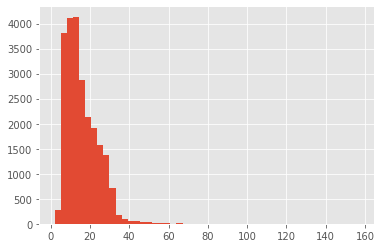

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist([len(s) for s in train], bins=50)
plt.show()

In [ ]:
def  split(sentences, max):
    new=[]
    for data in sentences:
        new.append(([data[x:x+max] for x in range(0, len(data), max)]))
    new = [val for sublist in new for val in sublist]
    return new



train = split(train, MAX_SEQUENCE_LENGTH)
dev = split(dev, MAX_SEQUENCE_LENGTH)
test = split(test, MAX_SEQUENCE_LENGTH)    

In [ ]:
train = train + dev

In [ ]:
# Some usefull functions
def tag_sequence(sentences):
    return [[t for w, t in sentence] for sentence in sentences]

def text_sequence(sentences):
    return [[w for w, t in sentence] for sentence in sentences]

In [ ]:
train_text = text_sequence(train)
test_text = text_sequence(test)

train_label = tag_sequence(train)
test_label= tag_sequence(test)

In [ ]:
len(train_text)


23488

In [ ]:
train_text[0], train_label[0]


(['license',
  'plates',
  'of',
  'cars',
  'from',
  'your',
  'area',
  'or',
  'your',
  'destination',
  '.'],
 ['NON-VERB',
  'VERB',
  'VERB',
  'VERB',
  'VERB',
  'VERB',
  'VERB',
  'VERB',
  'VERB',
  'VERB',
  'VERB'])

# BERT Implementation

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 5.7MB/s 
     |████████████████████████████████| 901kB 44.3MB/s 
     |████████████████████████████████| 3.3MB 30.4MB/s 


In [ ]:
#Convert token to BERT

from transformers import BertTokenizer
tz = BertTokenizer.from_pretrained("bert-base-uncased")

sent = "Let's learn deep learning!"

# Encode the sentence
encoded = tz.encode_plus(
    text=sent,  # the sentence to be encoded
    add_special_tokens=True,  # Add [CLS] and [SEP]
    max_length = 64,  # maximum length of a sentence
    pad_to_max_length=True,  # Add [PAD]s
    return_attention_mask = True,  # Generate the attention mask
    return_tensors = 'pt',  # ask the function to return PyTorch tensors
)

# Get the input IDs and attention mask in tensor format
input_ids = encoded['input_ids']
attn_mask = encoded['attention_mask']


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
input_ids

tensor([[ 101, 2292, 1005, 1055, 4553, 2784, 4083,  999,  102,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]])

In [ ]:
attn_mask


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.
  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label_ids = [0] * max_seq_length
        return input_ids, input_mask, segment_ids, label_ids
    
    tokens_a = example.text_a
    if len(tokens_a) > max_seq_length-2:
        tokens_a = tokens_a[0 : (max_seq_length-2)]

# Token map will be an int -> int mapping between the `orig_tokens` index and
# the `bert_tokens` index.

# bert_tokens == ["[CLS]", "john", "johan", "##son", "'", "s", "house", "[SEP]"]
# orig_to_tok_map == [1, 2, 4, 6]   
    orig_to_tok_map = []              
    tokens = []
    segment_ids = []
    
    tokens.append("[CLS]")
    segment_ids.append(0)
    orig_to_tok_map.append(len(tokens)-1)
    #print(len(tokens_a))
    for token in tokens_a:       
        tokens.extend(tokenizer.tokenize(token))
        orig_to_tok_map.append(len(tokens)-1)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)
    orig_to_tok_map.append(len(tokens)-1)
    input_ids = tokenizer.convert_tokens_to_ids([tokens[i] for i in orig_to_tok_map])
    #print(len(orig_to_tok_map), len(tokens), len(input_ids), len(segment_ids)) #for debugging

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)
    
    label_ids = []
    labels = example.label
    label_ids.append(0)
    label_ids.extend([tag2int[label] for label in labels])
    label_ids.append(0)
    #print(len(label_ids)) #for debugging
    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)
        label_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length
    assert len(label_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, label_ids

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=text, text_b=None, label=label)
        )
    return InputExamples

In [ ]:
# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module()

NameError: ignored

In [ ]:
def bert_labels(labels):
    train_label_bert = []
    train_label_bert.append('-PAD-')
    for i in labels:
        train_label_bert.append(i)
    train_label_bert.append('-PAD-')
    print('BERT labels:', train_label_bert)


In [ ]:
tokens_a = train_text[2]

In [ ]:
orig_to_tok_map = []              
tokens = []
segment_ids = []
tokens.append("[CLS]")
segment_ids.append(0)
orig_to_tok_map.append(len(tokens)-1)
for token in tokens_a:
    #orig_to_tok_map.append(len(tokens)) # keep first piece of tokenized term
    tokens.extend(tokenizer.tokenize(token))
    orig_to_tok_map.append(len(tokens)-1) # # keep last piece of tokenized term -->> gives better results!
    segment_ids.append(0)
tokens.append("[SEP]")
segment_ids.append(0)
orig_to_tok_map.append(len(tokens)-1)
input_ids = tokenizer.convert_tokens_to_ids([tokens[i] for i in orig_to_tok_map])

In [ ]:
print('Original tokens:',tokens_a)


Original tokens: ['we', 'also', 'find', 'out', 'the', 'real', 'reason', 'for', 'phil', 'being', 'late', 'this', 'morning', ':', 'he', 'was', 'presenting', 'his', 'portfolio', 'at', 'the', 'glasgow', 'school', 'of', 'art.', 'he', 'is', 'now', 'waiting', 'on', 'a', 'phone', 'call', 'that', 'will', 'tell', 'him', 'how', 'he', 'got', 'on', '.']


In [ ]:
print('BERT tokens:',tokens)


BERT tokens: ['[CLS]', 'we', 'also', 'find', 'out', 'the', 'real', 'reason', 'for', 'phil', 'being', 'late', 'this', 'morning', ':', 'he', 'was', 'presenting', 'his', 'portfolio', 'at', 'the', 'glasgow', 'school', 'of', 'art', '.', 'he', 'is', 'now', 'waiting', 'on', 'a', 'phone', 'call', 'that', 'will', 'tell', 'him', 'how', 'he', 'got', 'on', '.', '[SEP]']


In [ ]:
bert_labels(train_label[2])


BERT labels: ['-PAD-', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', 'VERB', '-PAD-']


In [ ]:
orig_to_tok_map

print(input_ids)


[101, 2057, 2036, 2424, 2041, 1996, 2613, 3114, 2005, 6316, 2108, 2397, 2023, 2851, 1024, 2002, 2001, 10886, 2010, 11103, 2012, 1996, 6785, 2082, 1997, 1012, 2002, 2003, 2085, 3403, 2006, 1037, 3042, 2655, 2008, 2097, 2425, 2032, 2129, 2002, 2288, 2006, 1012, 102]


# Test the conversion of an example to BERT representation¶


In [ ]:
"""Create InputExamples"""
InputExamples = []
for text, label in zip(train_text[0:1], train_label[0:1]):
    InputExamples.append(
        InputExample(guid=None, text_a=text, text_b=None, label=label)
)
    

input_ids, input_masks, segment_ids, labels = [], [], [], []
for example in tqdm_notebook(InputExamples, desc="Converting examples to features"):
    input_id, input_mask, segment_id, label = convert_single_example(
        tokenizer, example, MAX_SEQUENCE_LENGTH+2
    )
    input_ids.append(input_id)
    input_masks.append(input_mask)
    segment_ids.append(segment_id)
    labels.append(label)    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# Convert data to InputExample format
train_examples = convert_text_to_examples(train_text, train_label)
test_examples = convert_text_to_examples(test_text, test_label)


# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels_ids
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=MAX_SEQUENCE_LENGTH+2)
(test_input_ids, test_input_masks, test_segment_ids, test_labels_ids
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=MAX_SEQUENCE_LENGTH+2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
print(len(train_input_ids[0]))
print(len(train_input_masks[0]))
print(len(train_segment_ids[0]))
print(len(train_labels_ids[0]))

72
72
72
72


In [ ]:
train_input_ids[0]


array([ 101, 6105, 7766, 1997, 3765, 2013, 2115, 2181, 2030, 2115, 7688,
       1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

In [ ]:
train_input_masks[0]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [ ]:
train_segment_ids[0]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [ ]:
train_labels_ids[0]


array([0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [ ]:
n_tags

NameError: ignored

In [ ]:
from keras.utils import to_categorical
# One-hot encode labels
train_labels = to_categorical(train_labels_ids, num_classes=n_tags)
test_labels = to_categorical(test_labels_ids, num_classes=n_tags)

ImportError: ignored